# Gaussian Process Regressor

This script finds the best function of dv/v(Temp, precip.) by taking the mean of several fitted function. This methode is called Gaussian Process Regression (GPR). This script only uses one station, CC.RIO.

### Input
- preciopitation data for one station (ppt_RIO.npy)
- temperature data for one station (temp_RIO.npy)
- dv/v data for one station (dvv_RIO_filled.npy)

GPR can handle NaN but no empty data gaps. All used time series have to have the same length.

In [1]:
# load packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import GridSearchCV
import pickle
import time

In [2]:
# load files
ppt = np.load('../DATA/ppt_RIO.npy', allow_pickle=True)
relative_humidity = ppt[0]
temp = np.load('../DATA/temp_RIO.npy', allow_pickle=True)
temperature = temp[0]
dvv = np.load('../DATA/dvv_RIO_filled.npy', allow_pickle=True)
dvv_data = dvv[0]
print(len(temperature), len(relative_humidity), len(dvv_data))

7671 7671 7671


In [3]:
# rearrange the data

# Generate Velocity Change
velocity_change = np.array(dvv_data, dtype=np.float) # from object to float
velocity_change

# Clean Data with Nan Values
mask = np.isnan(velocity_change)
velocity_change = velocity_change[np.invert(mask)]

environmental_conditions = np.array([temperature[np.invert(mask)], relative_humidity[np.invert(mask)]])

times = ppt[1][np.invert(mask)]

# Sanity Check if ALl is okay !
print(environmental_conditions.shape, velocity_change.shape)

(2, 7486) (7486,)


/var/folders/ww/7sxdjthd63v4x53s8kwbqxpc0000gn/T/ipykernel_24432/4064841417.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  velocity_change = np.array(dvv_data, dtype=np.float) # from object to float


### Split Data-Set for training and testing

In [6]:
# split the data set in a test and a train data-set
X_train = environmental_conditions.transpose()[:2000]
X_test = environmental_conditions.transpose()[2000:]
y_train = velocity_change[:2000]
y_test = velocity_change[2000:]
print(X_test.shape,y_test.shape, X_train.shape,y_train.shape)

(5486, 2) (5486,) (2000, 2) (2000,)


I do not use train_test_split because I like to train with old data and predict the newer part of the data. If the goal is to fill seismic data gaps, run the cell belwo.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(environmental_conditions.transpose(), velocity_change, 
                                                    test_size=0.33, random_state=42)
print(X_test.shape,y_test.shape, X_train.shape,y_train.shape)

(2471, 2) (2471,) (5015, 2) (5015,)


### Train Model

In [7]:
# chooose a file name for the plots and the model
file_name = 'GPR'

In [8]:
# training the model
start_time = time.time()
#kernel = DotProduct() + WhiteKernel()
#kernel = C(1.0, (1e-3, 1e3)) * RBF([5,5], (1e-2, 1e2))
kernel = 1.0 * RBF(length_scale=1e-1, length_scale_bounds=(1e-20, 1e30)) + WhiteKernel(noise_level=1e-1, noise_level_bounds=(1e-20, 1e10))
#kernel = 1.0 * RBF(length_scale=500) + WhiteKernel(noise_level=1e-1, noise_level_bounds=(1e-20, 1e10))
gpr = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=0)
gpr.fit(X_train, y_train)
end_time = time.time()
print('calculation-time: {} s'.format(round(end_time-start_time,3)))
gpr.score(X_train, y_train)

calculation-time: 6.962 s


0.12679665399851714

In [9]:
# save the model
filename = '{}.model'.format(file_name)
pickle.dump(gpr, open(filename, 'wb'))

### Test Model

In [10]:
# load the model
filename = '{}.model'.format(file_name)
gprl = pickle.load(open(filename, 'rb'))

In [11]:
# make prediction useing the GPR model
y_pred, y_std = gpr.predict(X_test, return_std=True)

### Plotting

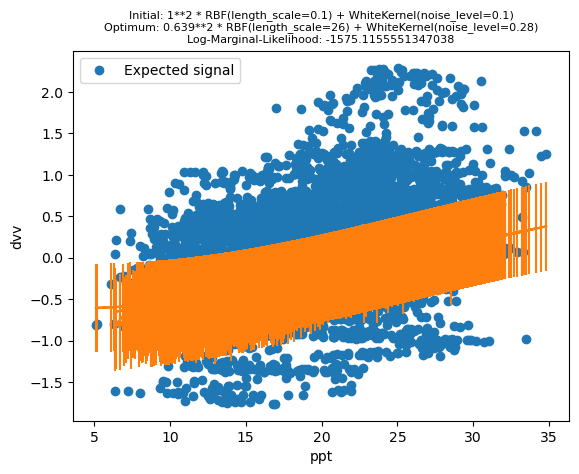

In [12]:
plt.plot(X_test[:,0], y_test, label="Expected signal", marker='o', linestyle='')
#plt.scatter(x=X_train[:, 0], y=y_train, color="black", alpha=0.4, label="Observations")
plt.errorbar(X_test[:,0], y_pred, y_std)
plt.legend()
plt.xlabel("ppt")
plt.ylabel("dvv")
_ = plt.title(
    f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: "
    f"{gpr.log_marginal_likelihood(gpr.kernel_.theta)}",
    fontsize=8,
)

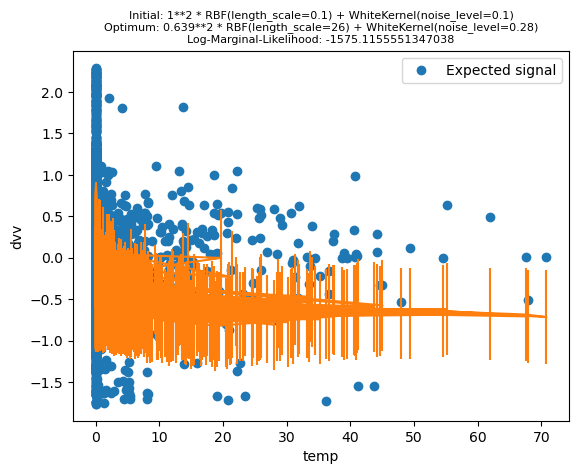

In [13]:
plt.plot(X_test[:,1], y_test, label="Expected signal", marker='o', linestyle='')
#plt.scatter(x=X_train[:, 0], y=y_train, color="black", alpha=0.4, label="Observations")
plt.errorbar(X_test[:,1], y_pred, y_std)
plt.legend()
plt.xlabel("temp")
plt.ylabel("dvv")
_ = plt.title(
    f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: "
    f"{gpr.log_marginal_likelihood(gpr.kernel_.theta)}",
    fontsize=8,
)

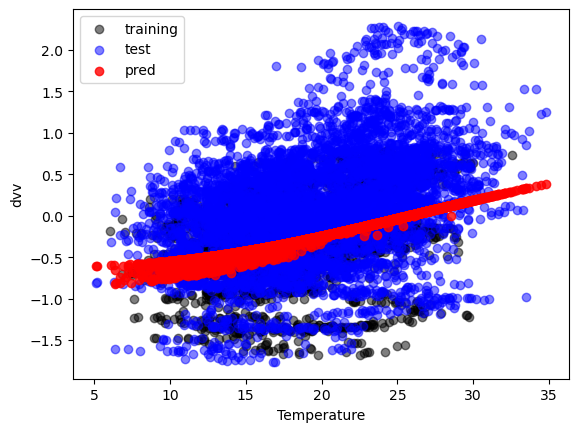

In [14]:
# Plot outputs
plt.scatter(X_train[:,0], y_train, color="black", label='training', alpha=0.5)
plt.scatter(X_test[:,0], y_test, color="blue", label='test', alpha=0.5)
plt.scatter(X_test[:,0], y_pred, color="red", label='pred', alpha=0.8)
plt.xlabel('Temperature')
plt.ylabel('dvv')
plt.legend()
#plt.savefig('../my_plots/'+file_name+'dvv_temp.png',dpi=300, bbox_inches='tight')

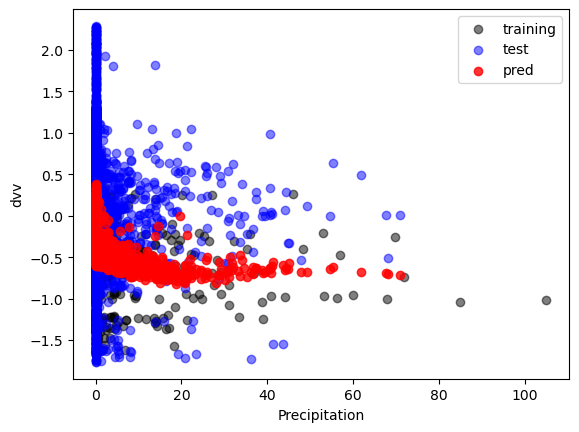

In [15]:
# Plot outputs
plt.scatter(X_train[:,1], y_train, color="black", label='training', alpha=0.5)
plt.scatter(X_test[:,1], y_test, color="blue", label='test', alpha=0.5)
plt.scatter(X_test[:,1], y_pred, color="red", label='pred', alpha=0.8)
plt.xlabel('Precipitation')
plt.ylabel('dvv')
plt.legend()
#plt.savefig('../my_plots/'+file_name+'dvv_ppt.png',dpi=300, bbox_inches='tight')

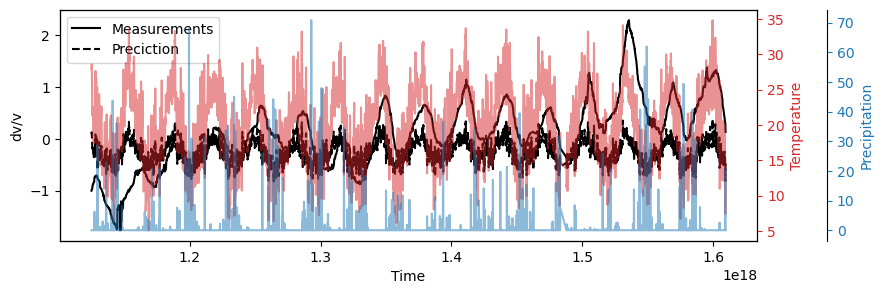

In [16]:
fig, ax = plt.subplots(figsize=(9,3))
ax1 = ax.twinx()
ax2 = ax.twinx()
ax.plot(times[2000:],y_test, 'black', label='Measurements')
ax.plot(times[2000:],y_pred, 'black', marker='', linestyle='--', label='Preciction')
ax1.plot(times[2000:],X_test[:,0], 'C3', alpha=0.5)
ax2.plot(times[2000:],X_test[:,1], 'C0', alpha=0.5)

#ax.set_xlim(1.565e18,1.61e18)

ax.set_xlabel("Time")
ax.set_ylabel("dv/v")
ax1.set_ylabel("Temperature")
ax2.set_ylabel("Precipitation")

ax1.yaxis.label.set_color('C3')
ax2.yaxis.label.set_color('C0')

ax1.tick_params(axis='y', colors='C3')
ax2.tick_params(axis='y', colors='C0')

ax2.spines.right.set_position(("axes", 1.1))

ax.legend(loc='upper left')
#plt.savefig('../my_plots/'+file_name+'pred.png',dpi=300, bbox_inches='tight')

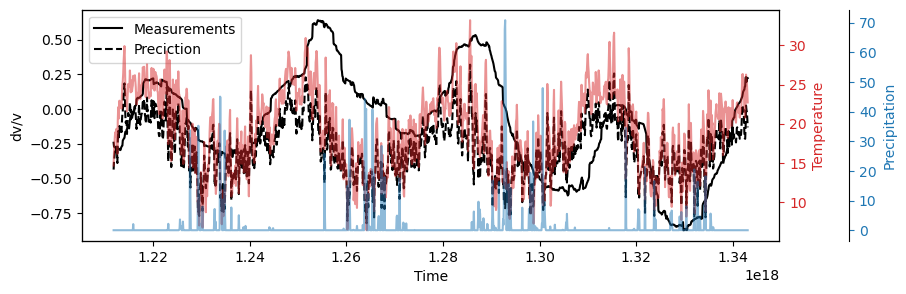

In [18]:
# zoom into figure above
fig, ax = plt.subplots(figsize=(9,3))
ax1 = ax.twinx()
ax2 = ax.twinx()
ax.plot(times[3000:4500],y_test[1000:2500], 'black', label='Measurements')
ax.plot(times[3000:4500],y_pred[1000:2500], 'black', marker='', linestyle='--', label='Preciction')
ax1.plot(times[3000:4500],X_test[1000:2500,0], 'C3', alpha=0.5)
ax2.plot(times[3000:4500],X_test[1000:2500,1], 'C0', alpha=0.5)

#ax.set_xlim(1.565e18,1.61e18)

ax.set_xlabel("Time")
ax.set_ylabel("dv/v")
ax1.set_ylabel("Temperature")
ax2.set_ylabel("Precipitation")

ax1.yaxis.label.set_color('C3')
ax2.yaxis.label.set_color('C0')

ax1.tick_params(axis='y', colors='C3')
ax2.tick_params(axis='y', colors='C0')

ax2.spines.right.set_position(("axes", 1.1))

ax.legend(loc='upper left')
plt.savefig('../my_plots/'+file_name+'pred_zoom.png',dpi=300, bbox_inches='tight')

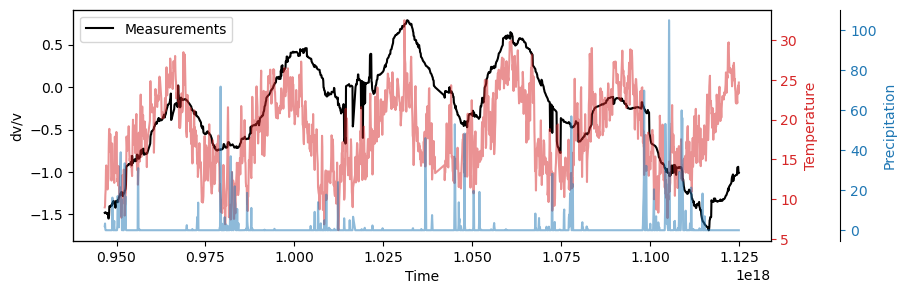

In [17]:
# this cell plots the only the training data set
fig, ax = plt.subplots(figsize=(9,3))
ax1 = ax.twinx()
ax2 = ax.twinx()
ax.plot(times[:2000],y_train, 'black', label='Measurements')
#ax.plot(times[:2000],y_pred, 'black', marker='', linestyle='--', label='Preciction')
ax1.plot(times[:2000],X_train[:,0], 'C3', alpha=0.5)
ax2.plot(times[:2000],X_train[:,1], 'C0', alpha=0.5)

#ax.set_xlim(1.565e18,1.61e18)

ax.set_xlabel("Time")
ax.set_ylabel("dv/v")
ax1.set_ylabel("Temperature")
ax2.set_ylabel("Precipitation")

ax1.yaxis.label.set_color('C3')
ax2.yaxis.label.set_color('C0')

ax1.tick_params(axis='y', colors='C3')
ax2.tick_params(axis='y', colors='C0')

ax2.spines.right.set_position(("axes", 1.1))

ax.legend(loc='upper left')
plt.savefig('../my_plots/'+file_name+'pred_train.png',dpi=300, bbox_inches='tight')

### Some additional check

In [ ]:
import pandas as pd
df = pd.DataFrame(index=times)
df.index = pd.to_datetime(df.index)
df['temp'] = environmental_conditions[0]
df['ppt'] = environmental_conditions[1]
df['dvv'] = velocity_change
df

,temp,ppt,dvv
2000-01-01,8.96,2.028,-1.480605
2000-01-02,9.117001,3.359,-1.478723
2000-01-03,10.506001,0.446,-1.473266
2000-01-04,11.198001,0.0,-1.475269
2000-01-05,13.684001,0.0,-1.478872
...,...,...,...
2020-12-27,14.460899,0.0,0.317491
2020-12-28,11.9499,16.660999,0.302796
2020-12-29,7.432,20.705,0.294836
2020-12-30,10.360499,0.0,0.168640


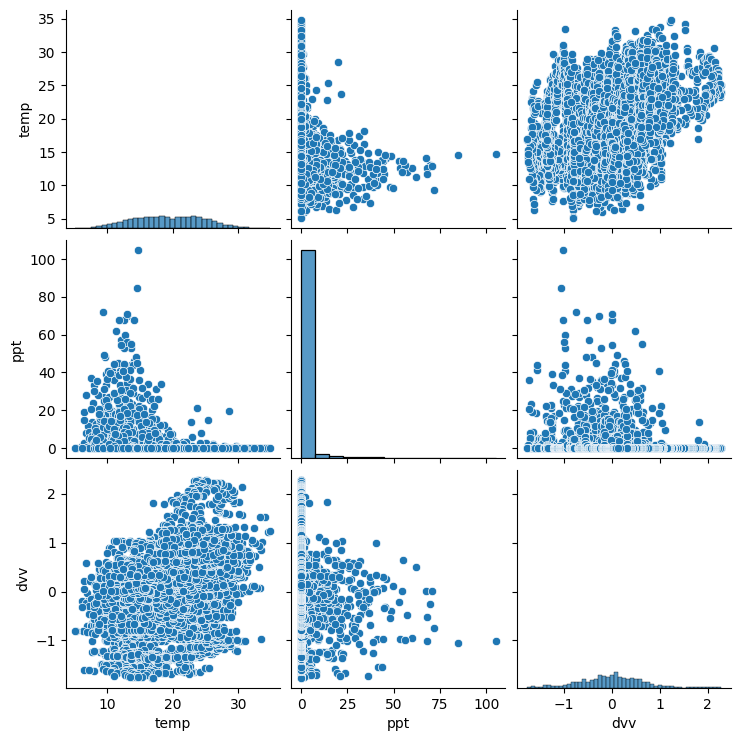

In [125]:
import seaborn as sns
sns.pairplot(df)